In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [2]:
from utils import Logger

In [3]:
def mnist_data():
    # Define transform pipeline for MNIST:
    # 1. Convert images to tensors
    # 2. Normalize pixel values to mean=0.5, std=0.5 (for grayscale, 1 channel)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Directory to store/download the dataset
    out_dir = './dataset'

    # Load MNIST training dataset with transform applied
    return datasets.MNIST(root=out_dir, train=True, transform=transform, download=True)

# Load data using the function
data = mnist_data()

# Create DataLoader to batch and shuffle the dataset
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

# Get number of batches per epoch (should be 600 for MNIST with batch_size=100)
num_batches = len(data_loader)
print(f"Number of batches: {num_batches}")


Number of batches: 600


In [4]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network.
    Used in GANs to distinguish between real and generated images.
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784   # MNIST image size (28x28 flattened)
        n_out = 1          # Binary output: real (1) or fake (0)
        
        # First hidden layer: 784 → 1024
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),   # LeakyReLU helps avoid dying ReLU problem
            nn.Dropout(0.3)      # Dropout for regularization
        )
        # Second hidden layer: 1024 → 512
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        # Third hidden layer: 512 → 256
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        # Output layer: 256 → 1 (probability real/fake)
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()   # Sigmoid maps output to [0,1]
        )

    def forward(self, x):
        # Pass input sequentially through hidden layers
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        # Final prediction (real/fake probability)
        x = self.out(x)
        return x

# Instantiate the discriminator
discriminator = DiscriminatorNet()


In [5]:
def images_to_vectors(images):
    # Convert a batch of images into flattened vectors
    # Input:  (batch_size, 1, 28, 28)  -> grayscale MNIST images
    # Output: (batch_size, 784)        -> flattened 28x28 = 784 vector
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    # Convert a batch of flattened vectors back into images
    # Input:  (batch_size, 784)        -> flattened vectors
    # Output: (batch_size, 1, 28, 28)  -> reshape into grayscale MNIST images
    return vectors.view(vectors.size(0), 1, 28, 28)

In [6]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network.
    Takes random noise as input and generates images (MNIST-sized).
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100   # Input noise vector size (latent dimension)
        n_out = 784        # Output size (28x28 image flattened)

        # First hidden layer: noise → 256
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)  # LeakyReLU helps gradient flow
        )
        # Second hidden layer: 256 → 512
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        # Third hidden layer: 512 → 1024
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        # Output layer: 1024 → 784 (flattened image)
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()          # Tanh outputs values in [-1, 1]
                               # MNIST images will be scaled to match this range
        )

    def forward(self, x):
        # Pass noise vector through hidden layers
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        # Output generated image (flattened)
        x = self.out(x)
        return x

# Instantiate the generator
generator = GeneratorNet()


In [7]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [8]:
# Optimizer for the Discriminator
# Using Adam optimizer with a small learning rate
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Optimizer for the Generator
# Separate optimizer so both networks can be trained alternately
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)


In [9]:
loss = nn.BCELoss()

In [10]:
def ones_target(size):
    '''
    Create a tensor of ones (label = 1 for real images).
    Shape: (size, 1)
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Create a tensor of zeros (label = 0 for fake images).
    Shape: (size, 1)
    '''
    data = Variable(torch.zeros(size, 1))
    return data


In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)   # Batch size
    
    # Reset discriminator gradients before each step
    optimizer.zero_grad()
    
    # ---- 1. Train on Real Data ----
    prediction_real = discriminator(real_data)                  # Discriminator output for real images
    error_real = loss(prediction_real, ones_target(N))          # Compare against target = 1 (real)
    error_real.backward()                                       # Backpropagate error
    
    # ---- 2. Train on Fake Data ----
    prediction_fake = discriminator(fake_data)                  # Discriminator output for fake images
    error_fake = loss(prediction_fake, zeros_target(N))         # Compare against target = 0 (fake)
    error_fake.backward()                                       # Backpropagate error
    
    # ---- 3. Update discriminator weights ----
    optimizer.step()
    
    # Return total error and predictions for monitoring
    return error_real + error_fake, prediction_real, prediction_fake


In [12]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)   # Batch size
    
    # Reset generator gradients before each step
    optimizer.zero_grad()
    
    # Run fake data through discriminator
    prediction = discriminator(fake_data)
    
    # Generator wants discriminator to classify fakes as real → target = 1
    error = loss(prediction, ones_target(N))
    
    # Backpropagate error
    error.backward()
    
    # Update generator weights
    optimizer.step()
    
    # Return generator loss for monitoring
    return error

In [13]:
num_test_samples = 16
test_noise = noise(num_test_samples)

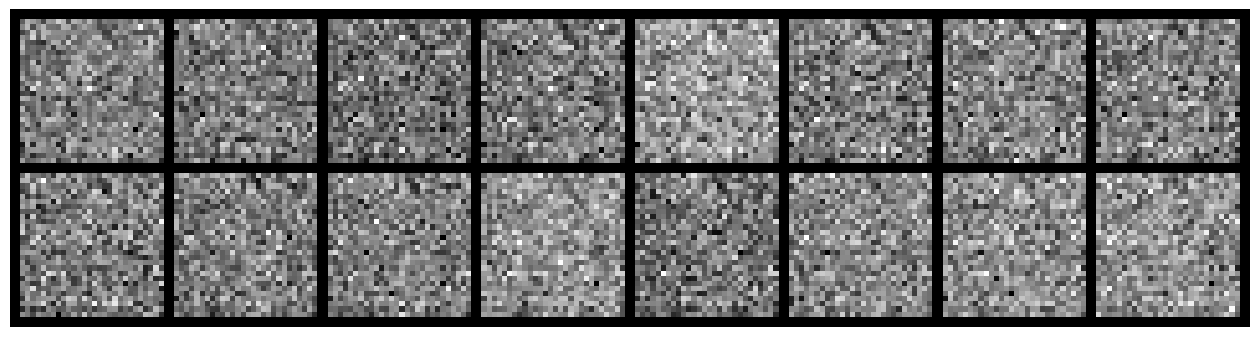

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.4121, Generator Loss: 0.7009
D(x): 0.4832, D(G(z)): 0.4955


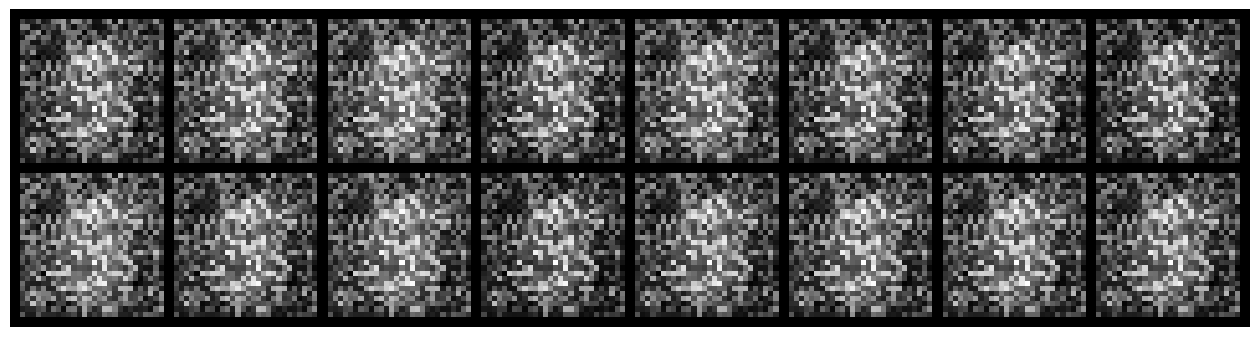

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 1.6175, Generator Loss: 1.4052
D(x): 0.6966, D(G(z)): 0.6509


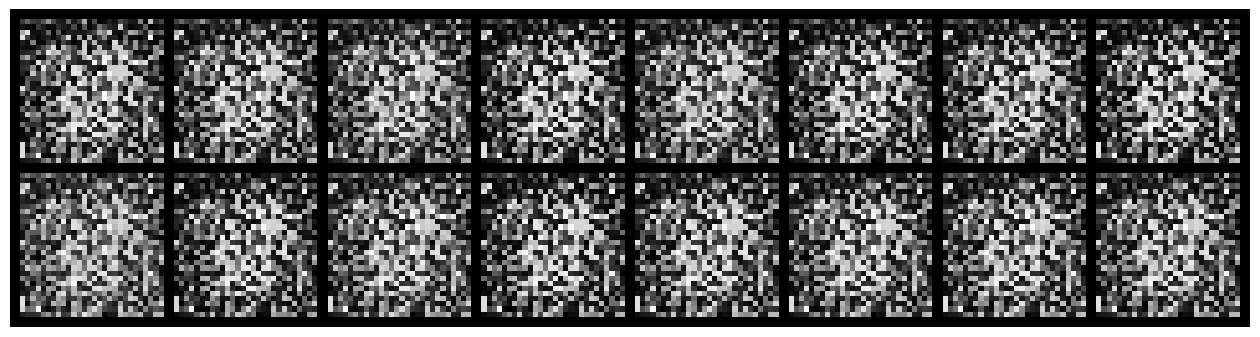

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.1276, Generator Loss: 4.6349
D(x): 0.9486, D(G(z)): 0.0677


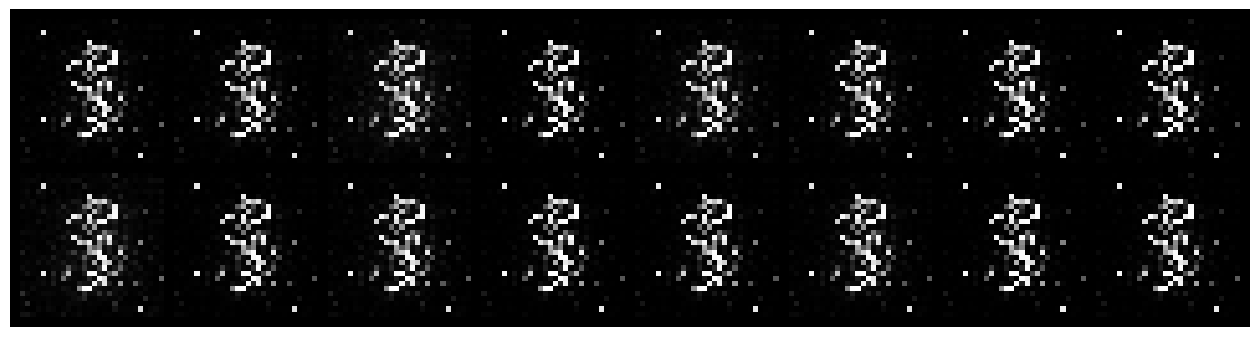

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.4138, Generator Loss: 3.7608
D(x): 0.8415, D(G(z)): 0.1323


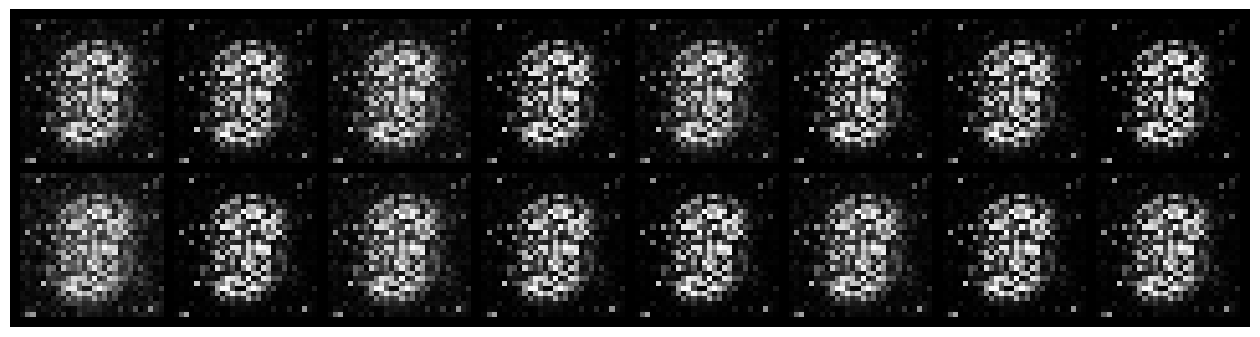

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 1.7283, Generator Loss: 1.8229
D(x): 0.5108, D(G(z)): 0.4571


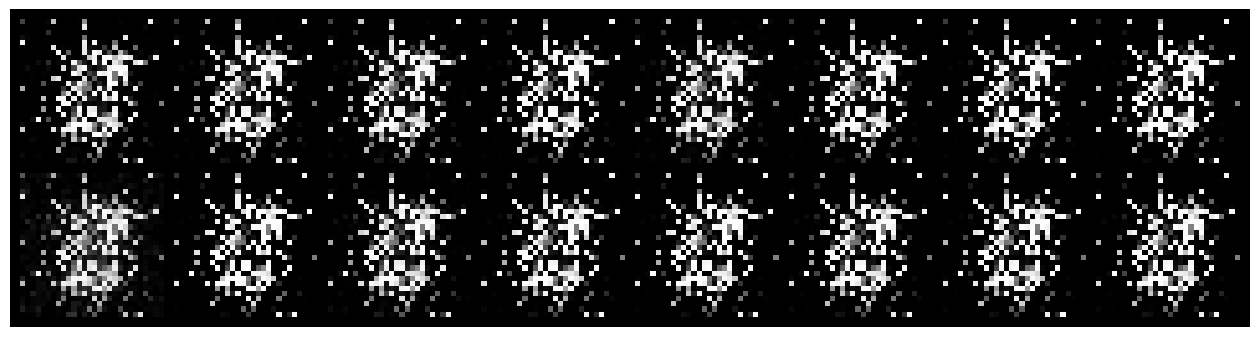

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 0.2450, Generator Loss: 3.2552
D(x): 0.9053, D(G(z)): 0.1266


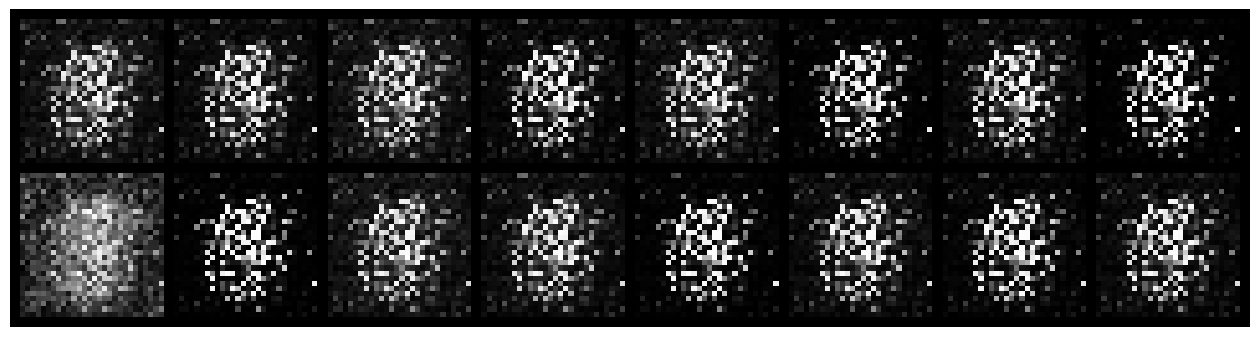

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.0508, Generator Loss: 7.6525
D(x): 0.9796, D(G(z)): 0.0245


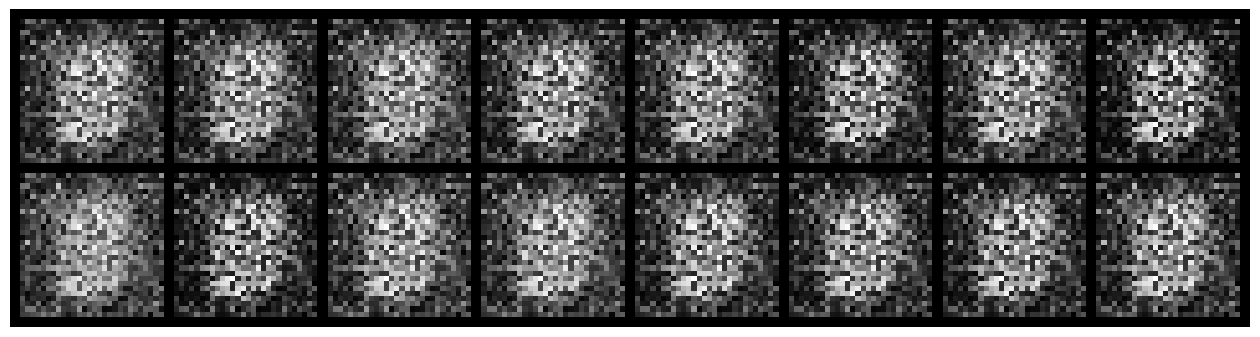

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 1.4359, Generator Loss: 1.9189
D(x): 0.6400, D(G(z)): 0.5122


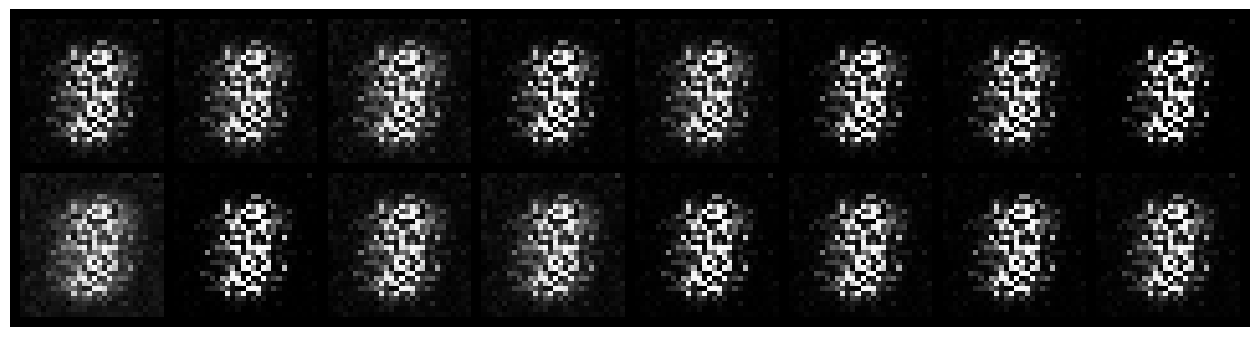

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 0.4631, Generator Loss: 3.3432
D(x): 0.8211, D(G(z)): 0.1716


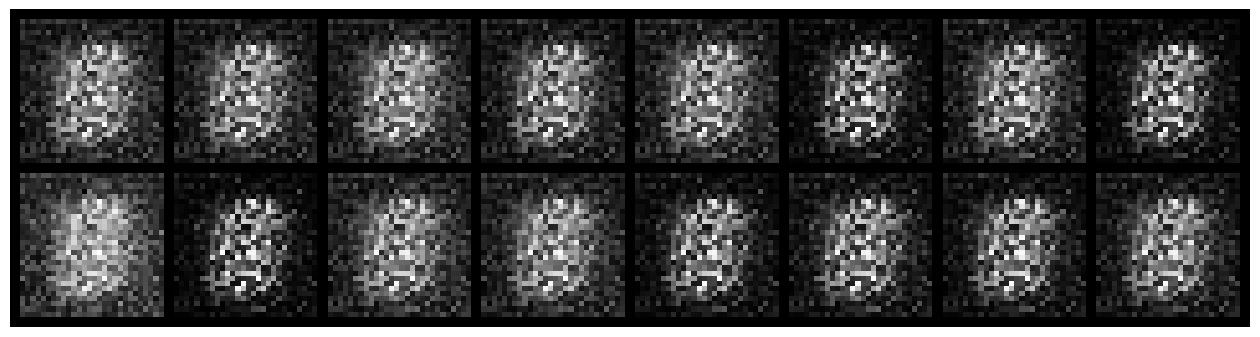

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.9629, Generator Loss: 1.5034
D(x): 0.6868, D(G(z)): 0.3611


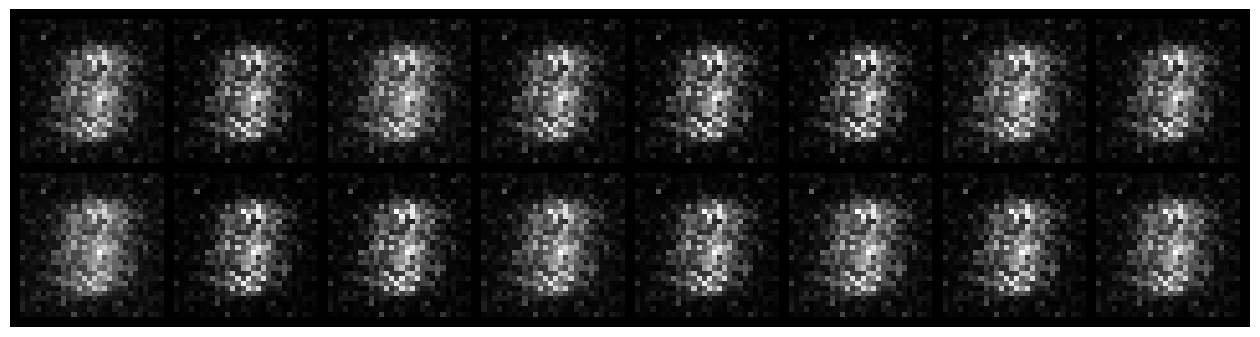

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 2.9402, Generator Loss: 0.6611
D(x): 0.4939, D(G(z)): 0.6542


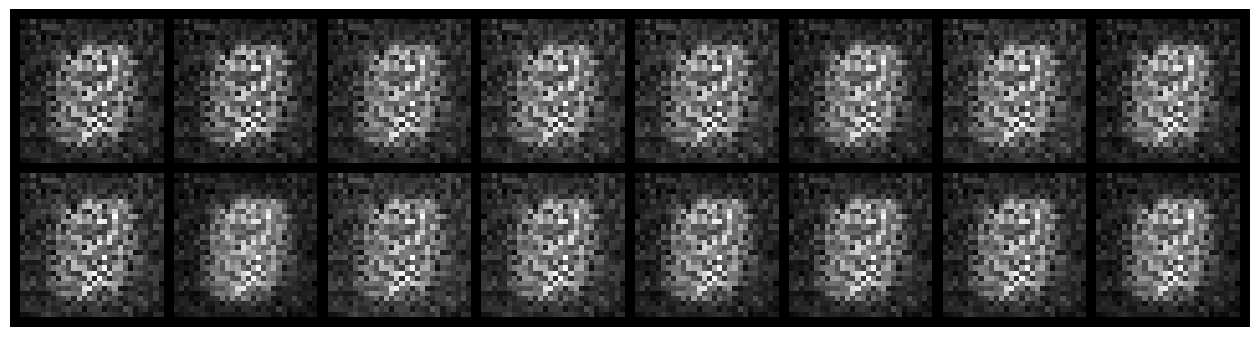

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 0.8936, Generator Loss: 1.2376
D(x): 0.7717, D(G(z)): 0.3999


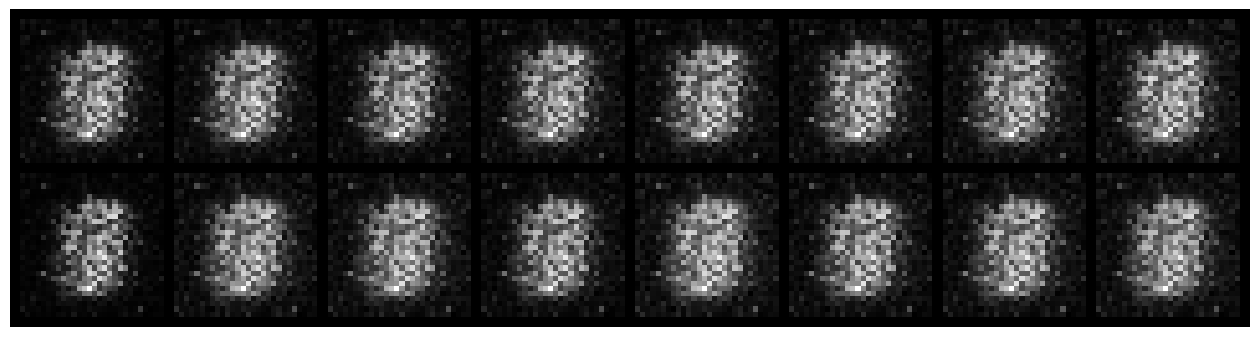

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 0.3261, Generator Loss: 3.1624
D(x): 0.9122, D(G(z)): 0.1734


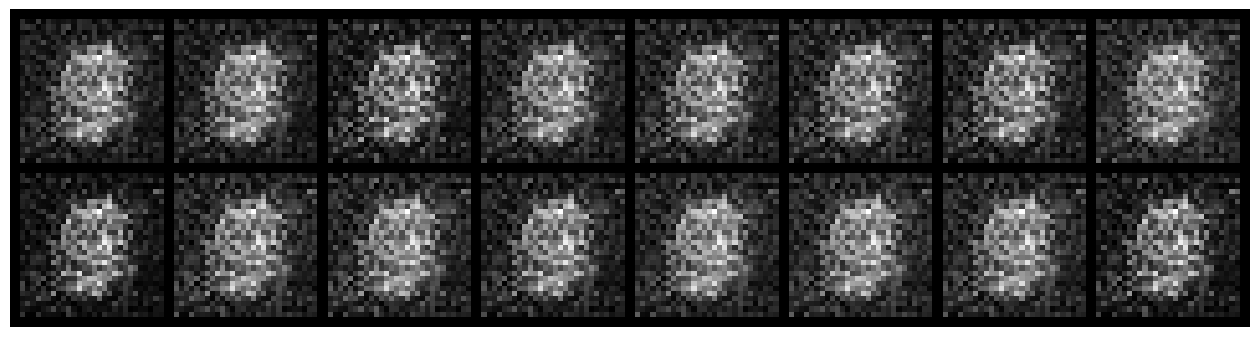

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 0.6633, Generator Loss: 1.7983
D(x): 0.7808, D(G(z)): 0.2722


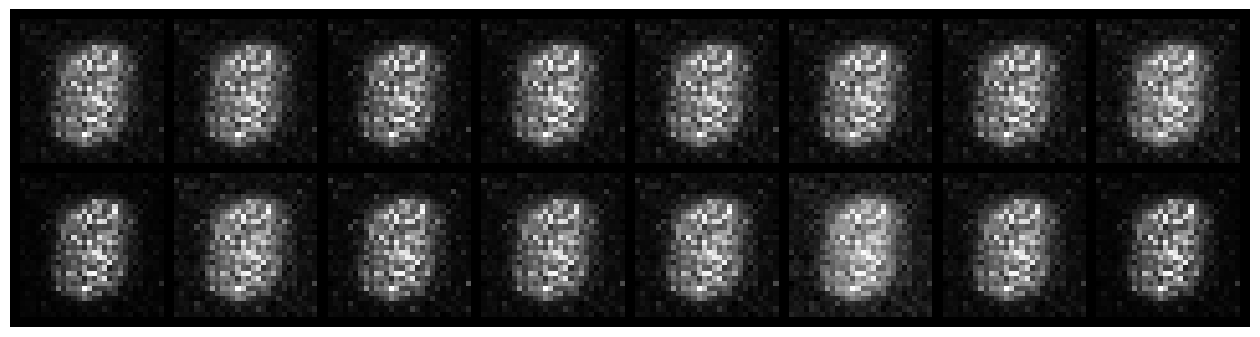

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 1.3378, Generator Loss: 1.0412
D(x): 0.6038, D(G(z)): 0.4530


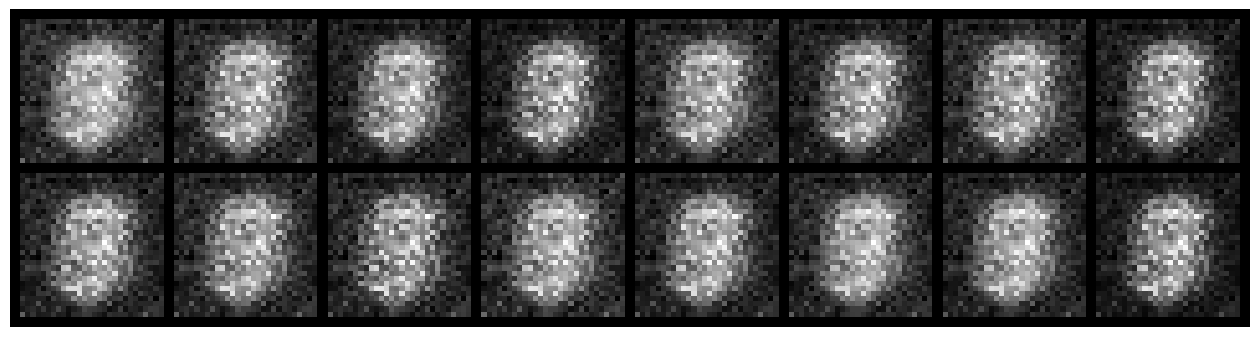

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 0.7807, Generator Loss: 1.8617
D(x): 0.7862, D(G(z)): 0.3102


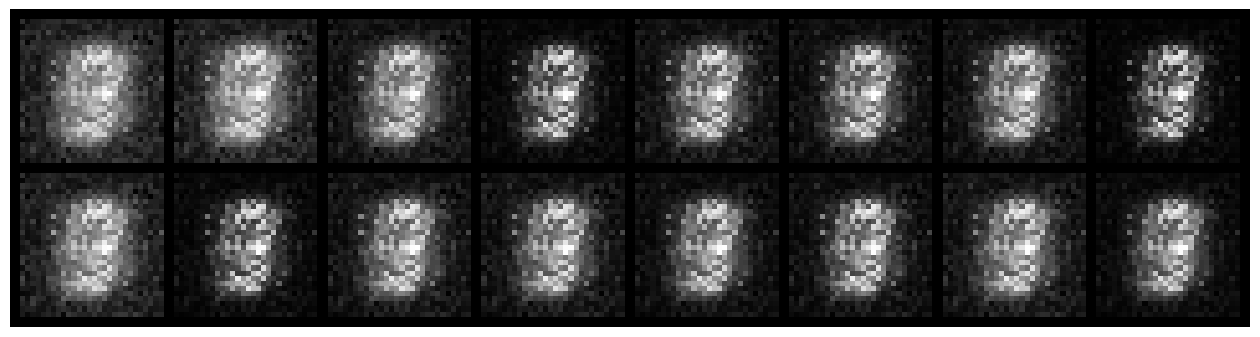

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 0.7011, Generator Loss: 2.1802
D(x): 0.8456, D(G(z)): 0.3361


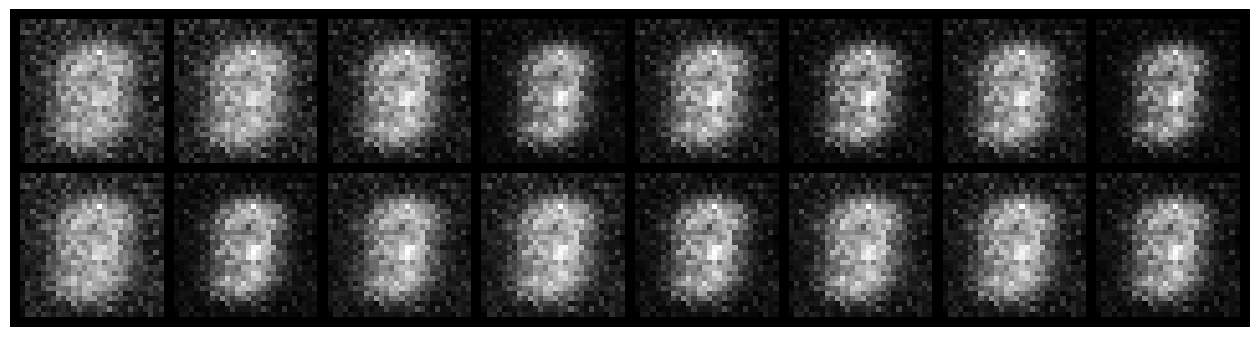

Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 0.6114, Generator Loss: 2.1011
D(x): 0.8022, D(G(z)): 0.2172


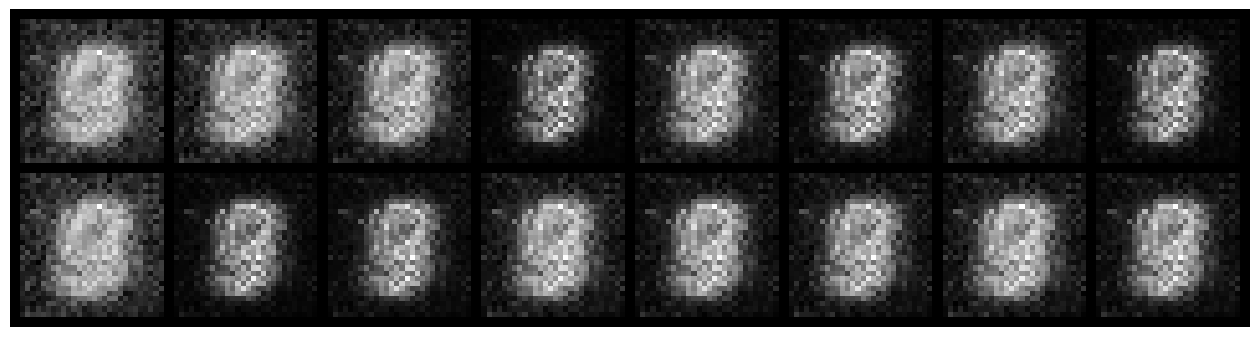

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 0.5642, Generator Loss: 1.9334
D(x): 0.8137, D(G(z)): 0.2033


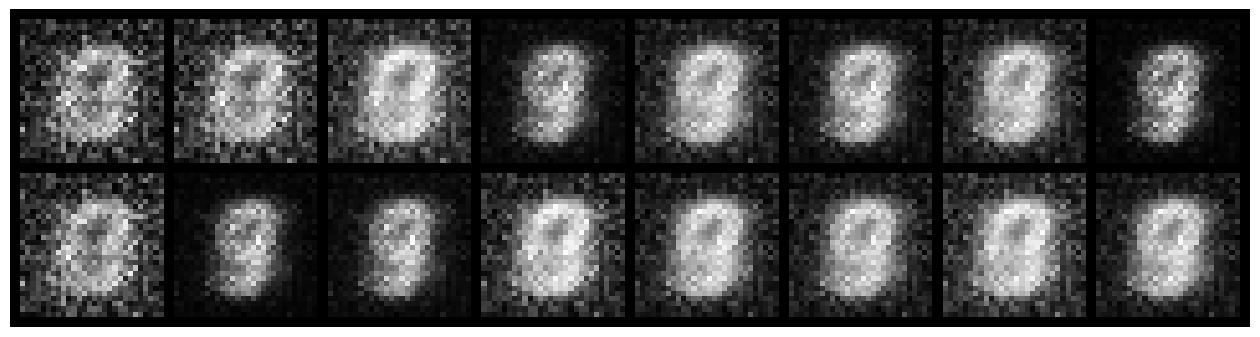

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 0.5451, Generator Loss: 2.8267
D(x): 0.8779, D(G(z)): 0.2065


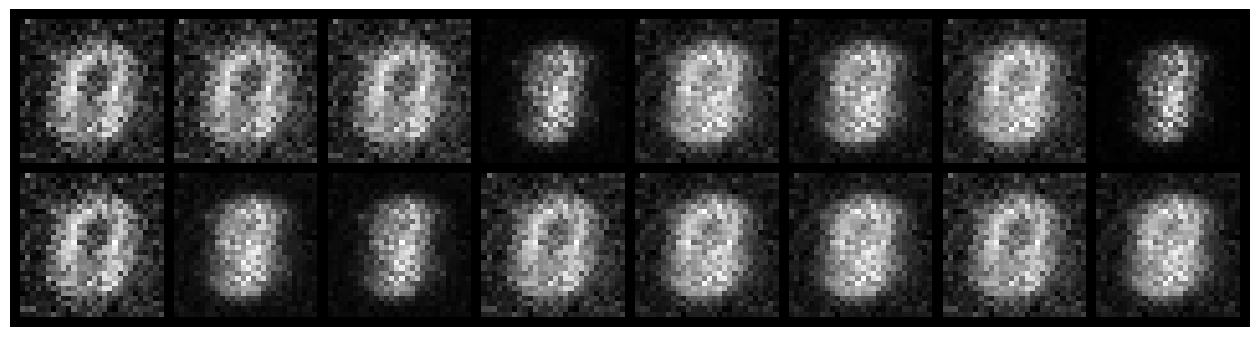

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.2679, Generator Loss: 2.9704
D(x): 0.9157, D(G(z)): 0.1287


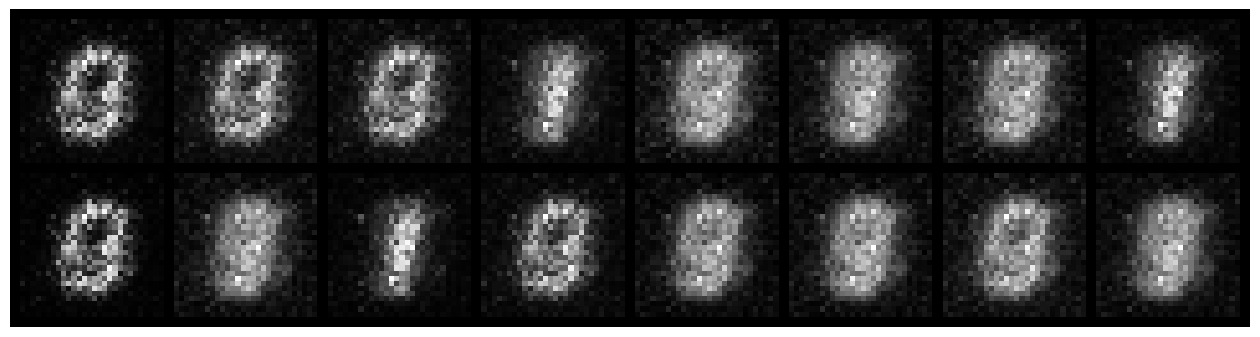

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 0.3976, Generator Loss: 3.3104
D(x): 0.8385, D(G(z)): 0.0687


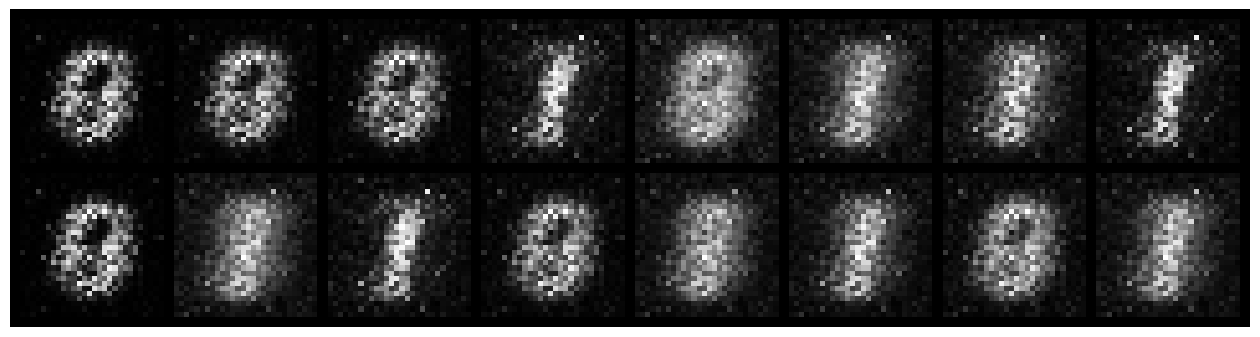

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.2734, Generator Loss: 3.1035
D(x): 0.9166, D(G(z)): 0.1031


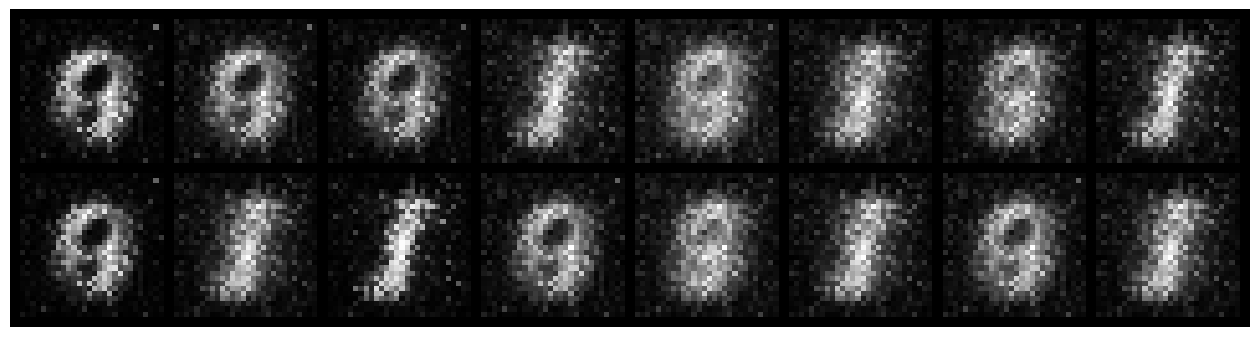

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 0.3516, Generator Loss: 3.5054
D(x): 0.9070, D(G(z)): 0.1165


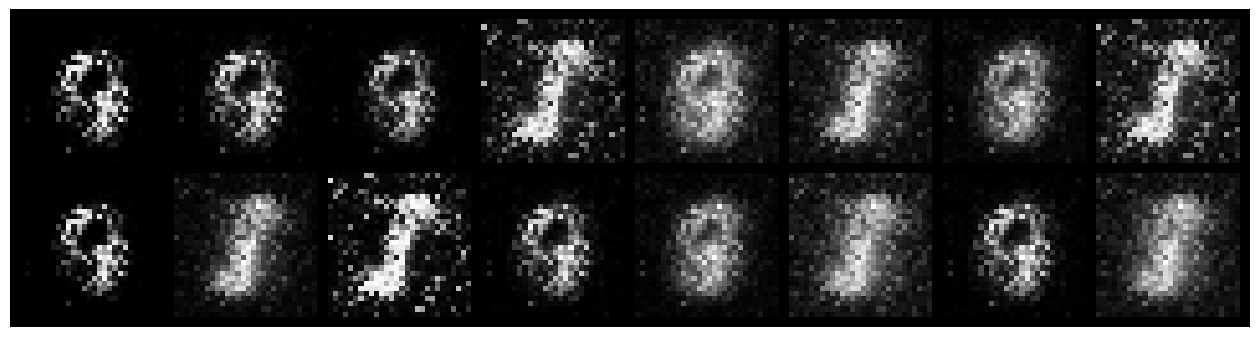

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.9087, Generator Loss: 3.0271
D(x): 0.7703, D(G(z)): 0.2347


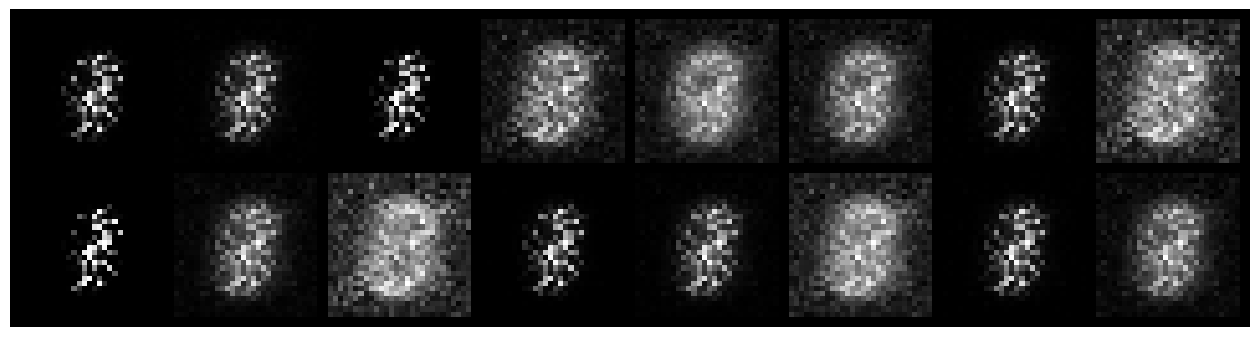

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.5780, Generator Loss: 2.5781
D(x): 0.8535, D(G(z)): 0.1509


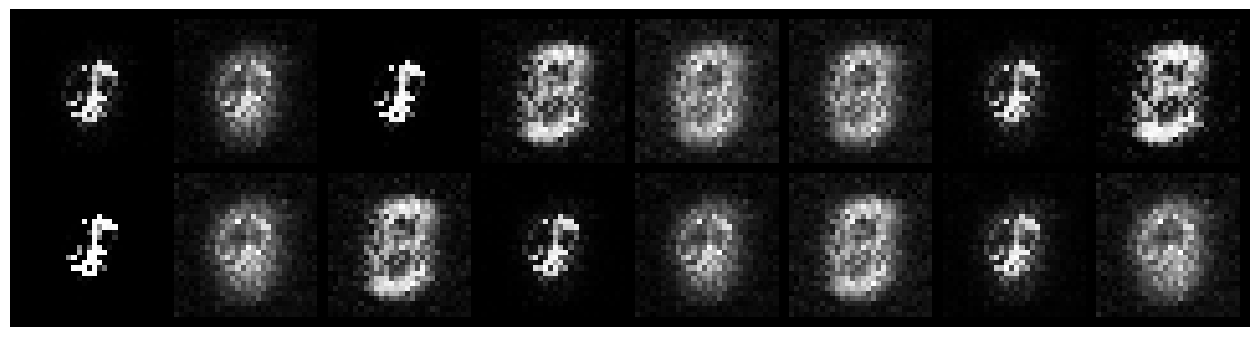

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.4520, Generator Loss: 2.8891
D(x): 0.8455, D(G(z)): 0.1272


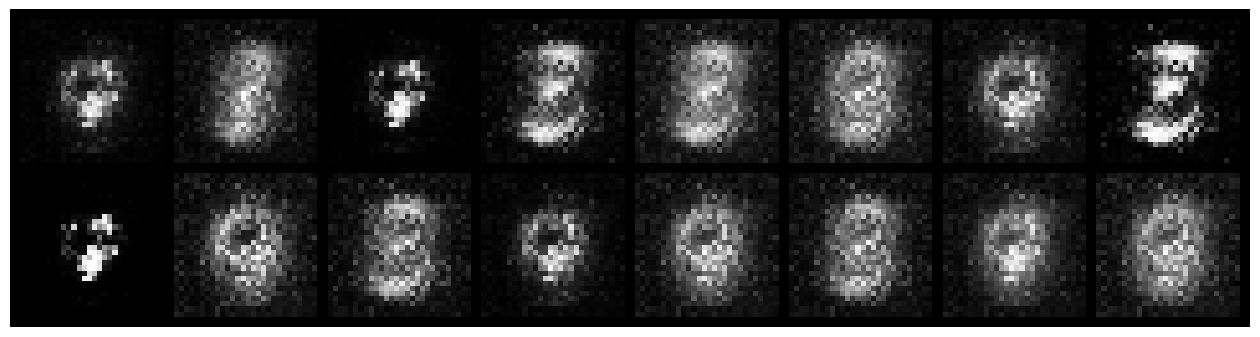

Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.6022, Generator Loss: 2.9107
D(x): 0.8240, D(G(z)): 0.2020


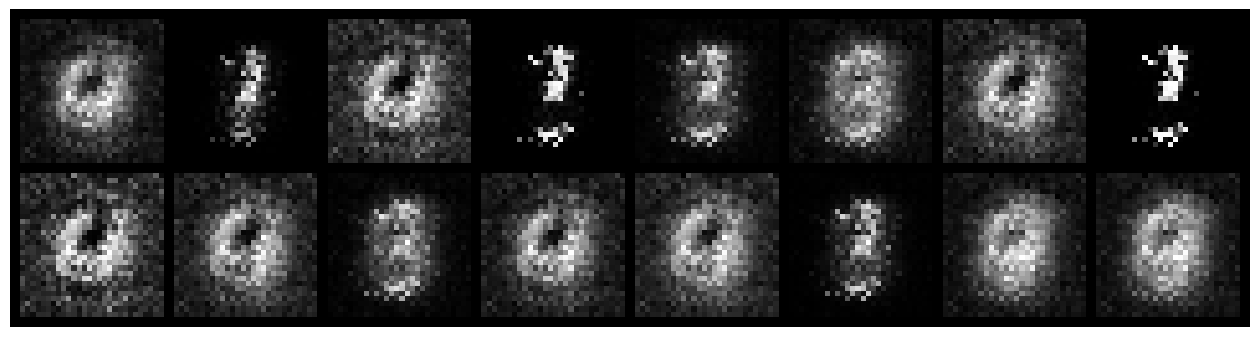

Epoch: [4/200], Batch Num: [400/600]
Discriminator Loss: 0.6597, Generator Loss: 2.3134
D(x): 0.8834, D(G(z)): 0.2884


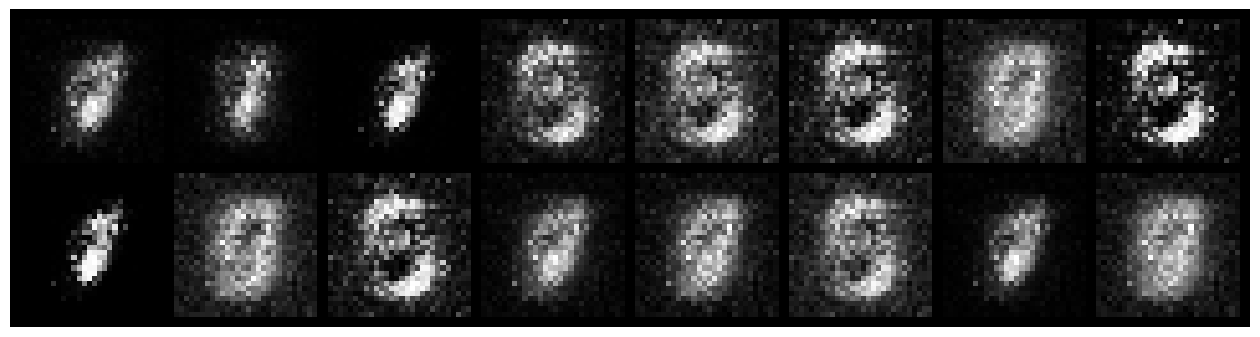

Epoch: [4/200], Batch Num: [500/600]
Discriminator Loss: 0.4515, Generator Loss: 2.6874
D(x): 0.8354, D(G(z)): 0.1284


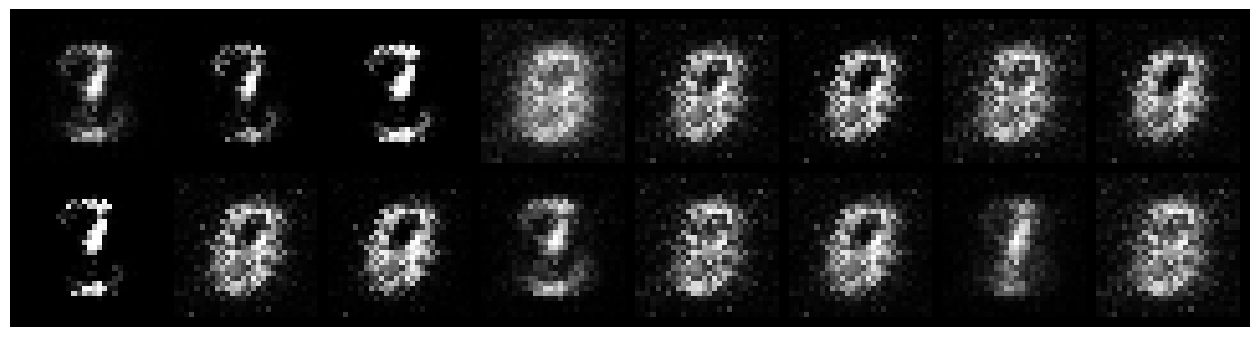

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.5969, Generator Loss: 3.0687
D(x): 0.8602, D(G(z)): 0.1689


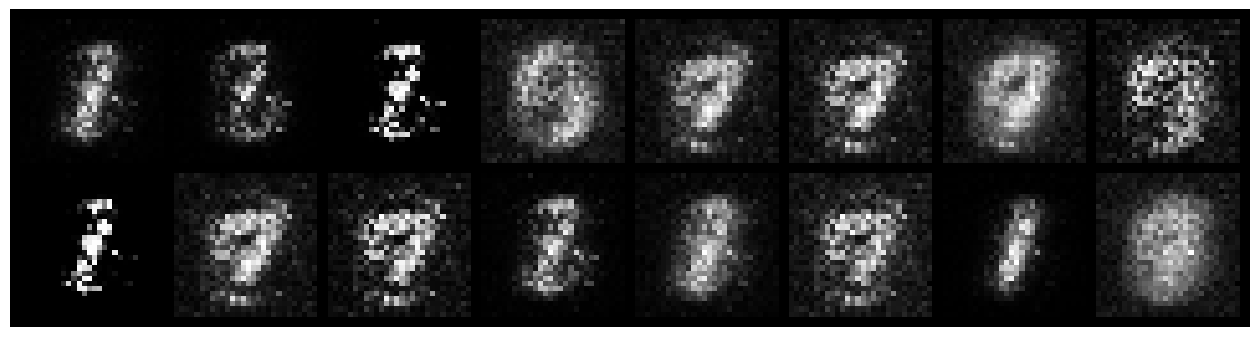

Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.7035, Generator Loss: 3.4146
D(x): 0.8307, D(G(z)): 0.2189


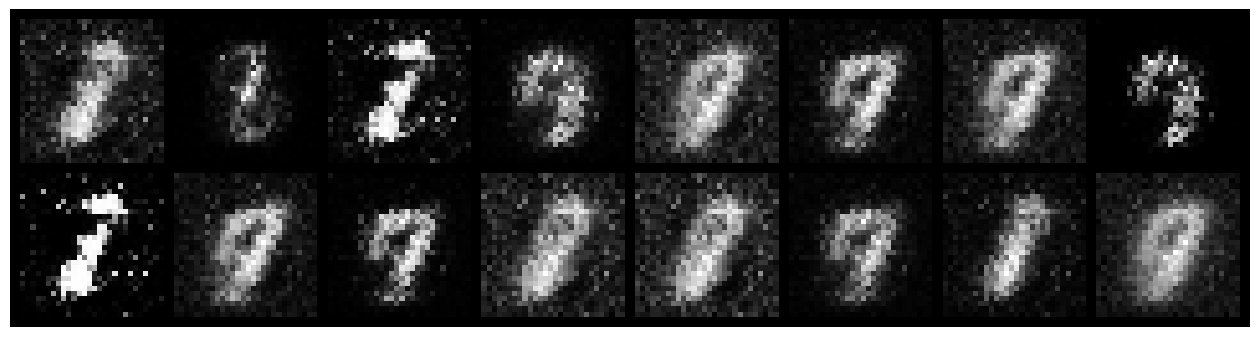

Epoch: [5/200], Batch Num: [200/600]
Discriminator Loss: 0.8962, Generator Loss: 1.7183
D(x): 0.7314, D(G(z)): 0.2255


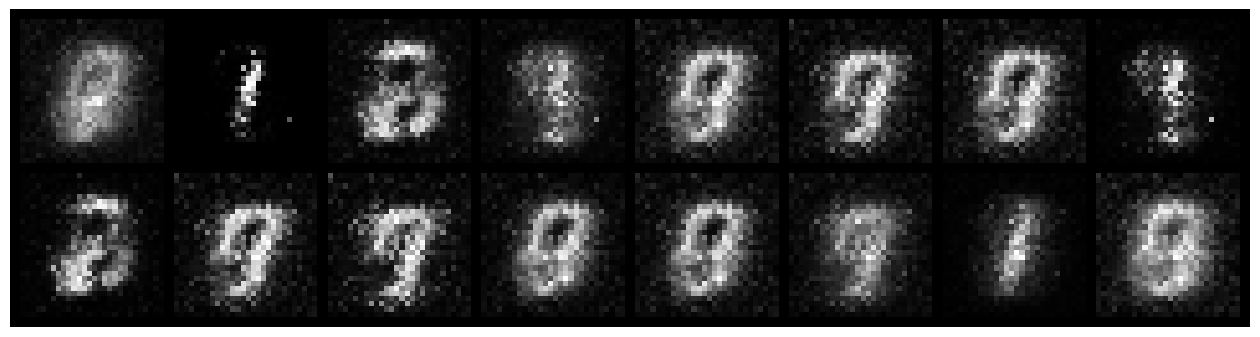

Epoch: [5/200], Batch Num: [300/600]
Discriminator Loss: 0.4856, Generator Loss: 2.8476
D(x): 0.8609, D(G(z)): 0.2006


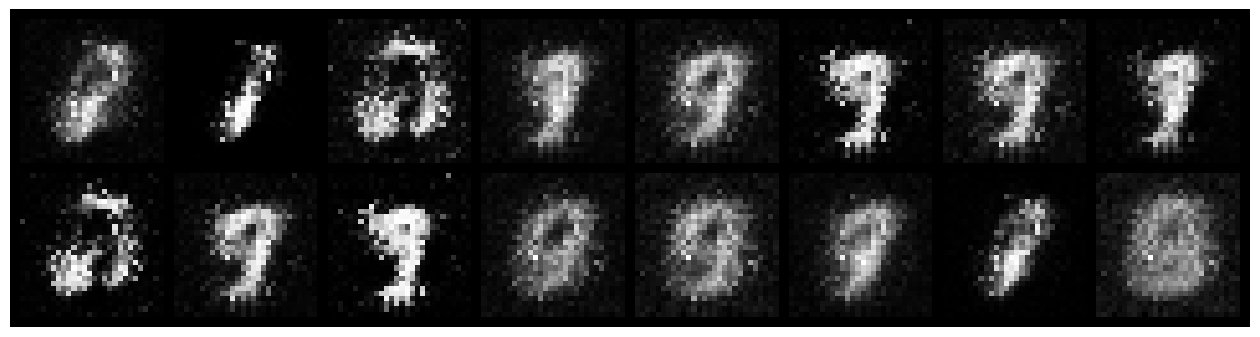

Epoch: [5/200], Batch Num: [400/600]
Discriminator Loss: 0.6954, Generator Loss: 2.0515
D(x): 0.8080, D(G(z)): 0.2065


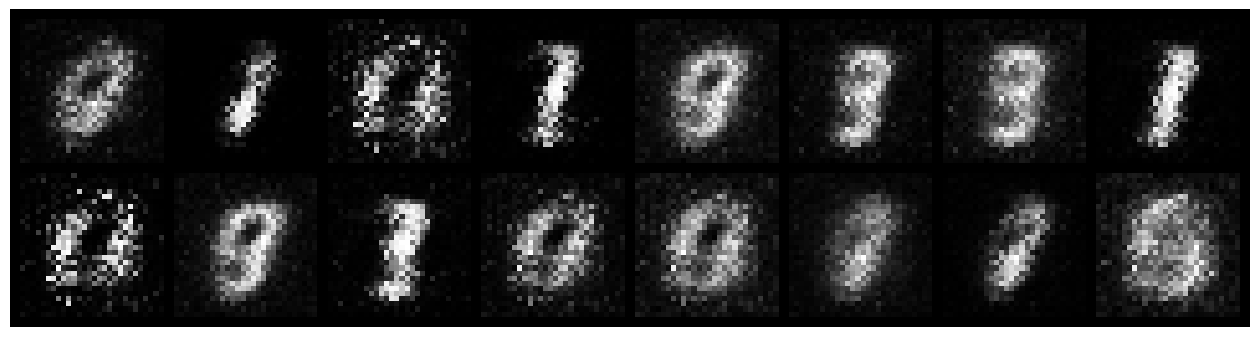

Epoch: [5/200], Batch Num: [500/600]
Discriminator Loss: 0.4205, Generator Loss: 3.0512
D(x): 0.8122, D(G(z)): 0.0891


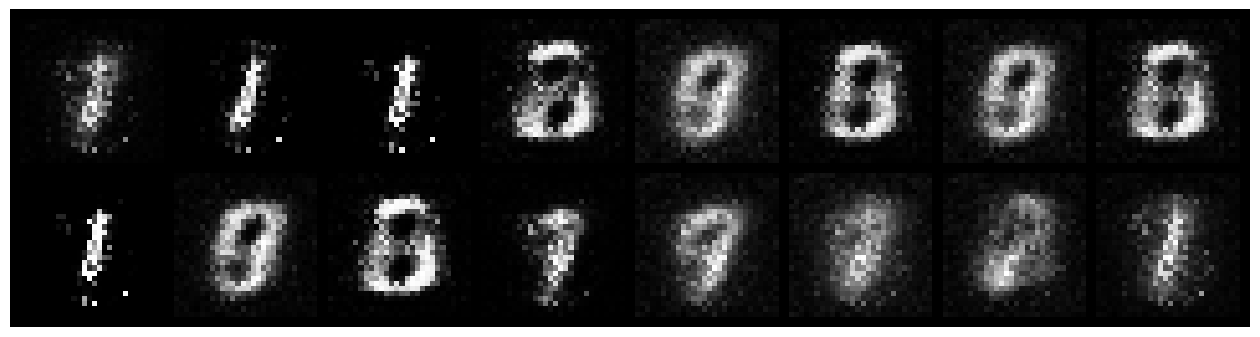

Epoch: [6/200], Batch Num: [0/600]
Discriminator Loss: 0.5981, Generator Loss: 2.8013
D(x): 0.7457, D(G(z)): 0.1081


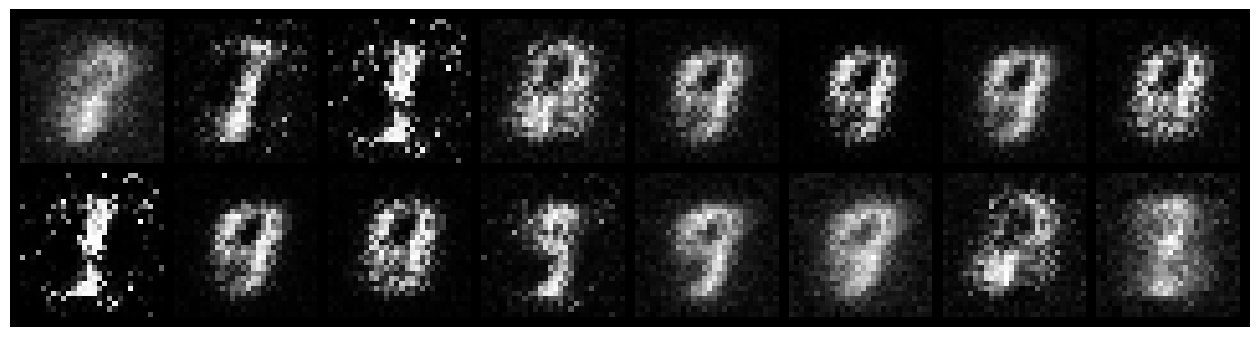

Epoch: [6/200], Batch Num: [100/600]
Discriminator Loss: 0.3807, Generator Loss: 2.7453
D(x): 0.8681, D(G(z)): 0.1276


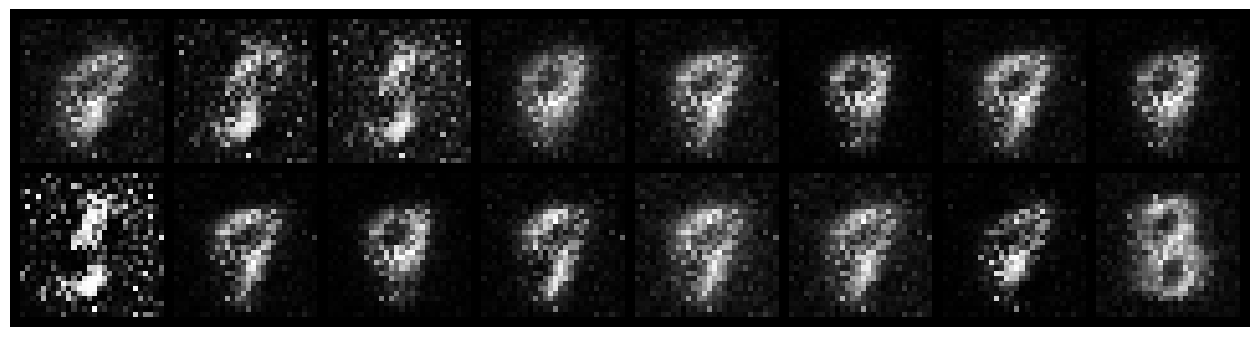

Epoch: [6/200], Batch Num: [200/600]
Discriminator Loss: 0.7281, Generator Loss: 1.4363
D(x): 0.8282, D(G(z)): 0.2661


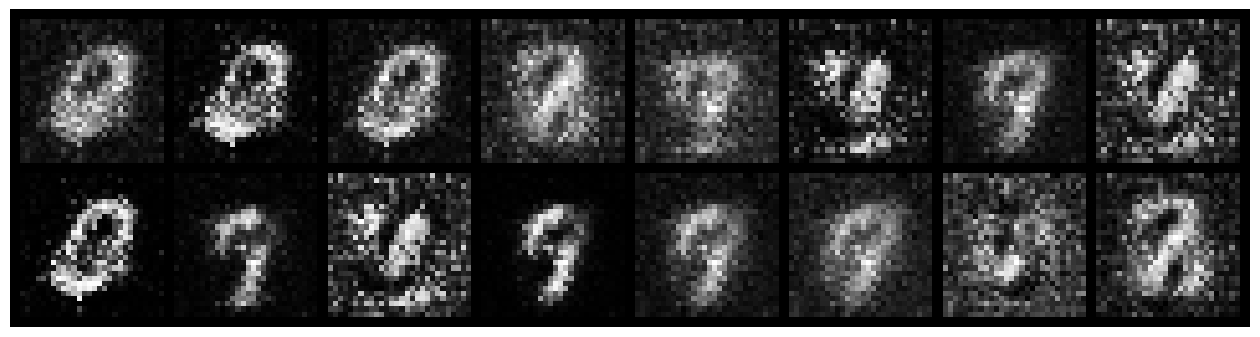

Epoch: [6/200], Batch Num: [300/600]
Discriminator Loss: 0.8531, Generator Loss: 2.8116
D(x): 0.7896, D(G(z)): 0.2866


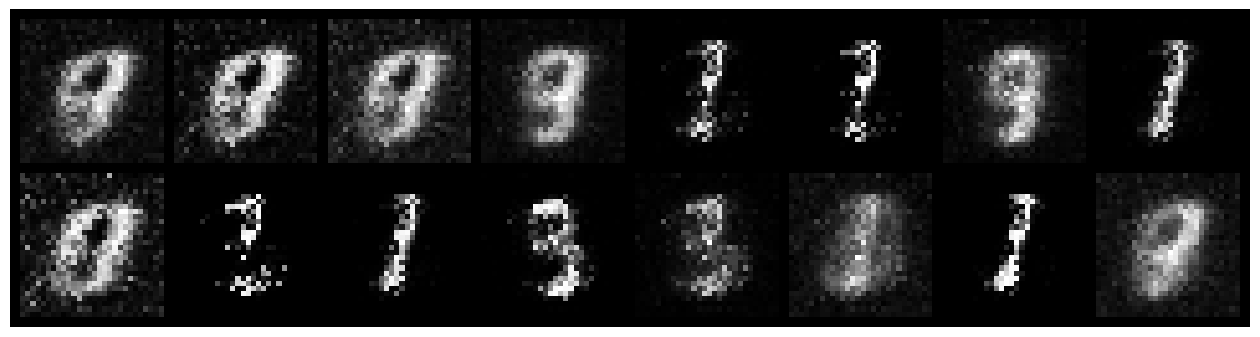

Epoch: [6/200], Batch Num: [400/600]
Discriminator Loss: 0.6674, Generator Loss: 2.4991
D(x): 0.8310, D(G(z)): 0.2130


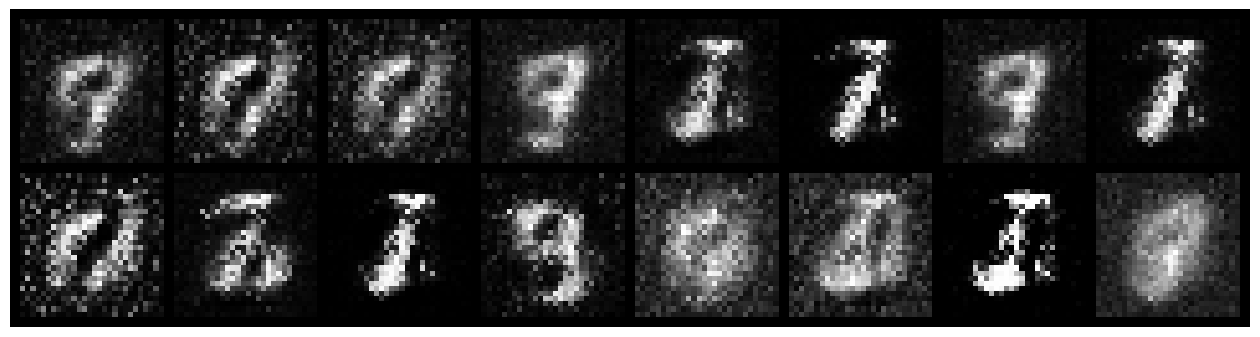

Epoch: [6/200], Batch Num: [500/600]
Discriminator Loss: 0.5697, Generator Loss: 2.8428
D(x): 0.8053, D(G(z)): 0.1340


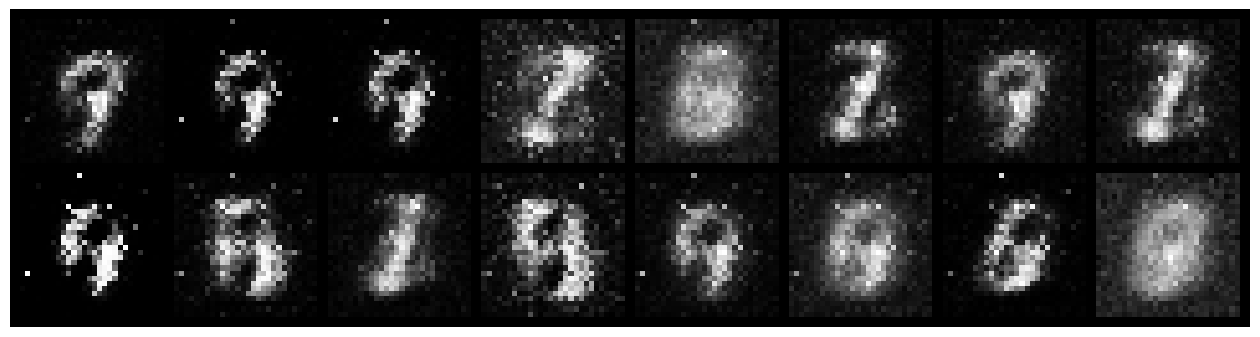

Epoch: [7/200], Batch Num: [0/600]
Discriminator Loss: 0.4563, Generator Loss: 2.2319
D(x): 0.8747, D(G(z)): 0.1822


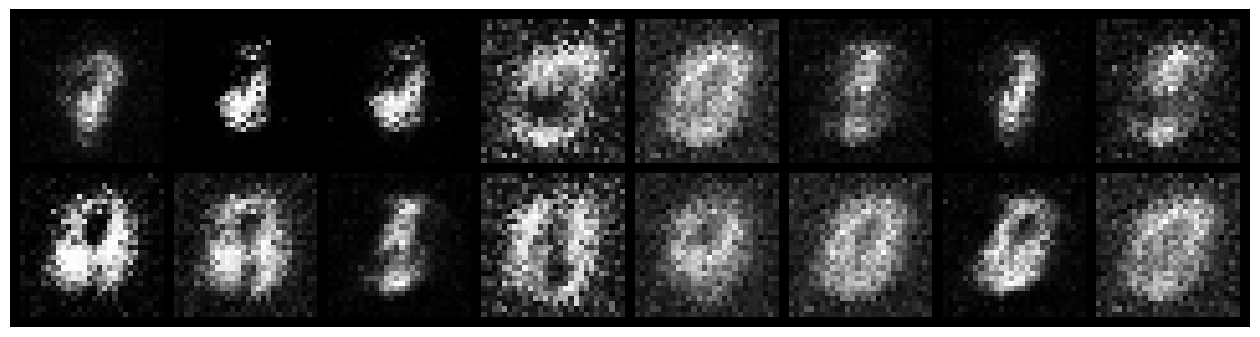

Epoch: [7/200], Batch Num: [100/600]
Discriminator Loss: 0.6378, Generator Loss: 2.1136
D(x): 0.8348, D(G(z)): 0.2431


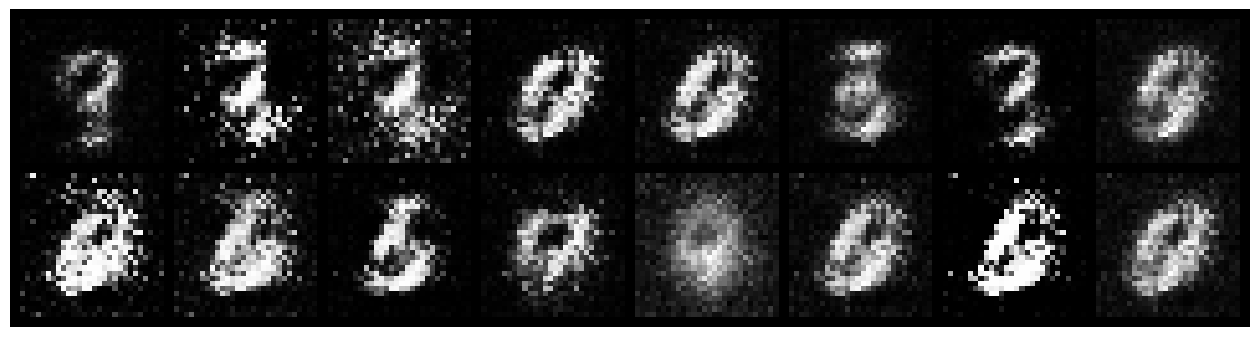

Epoch: [7/200], Batch Num: [200/600]
Discriminator Loss: 0.6886, Generator Loss: 2.0217
D(x): 0.7324, D(G(z)): 0.1167


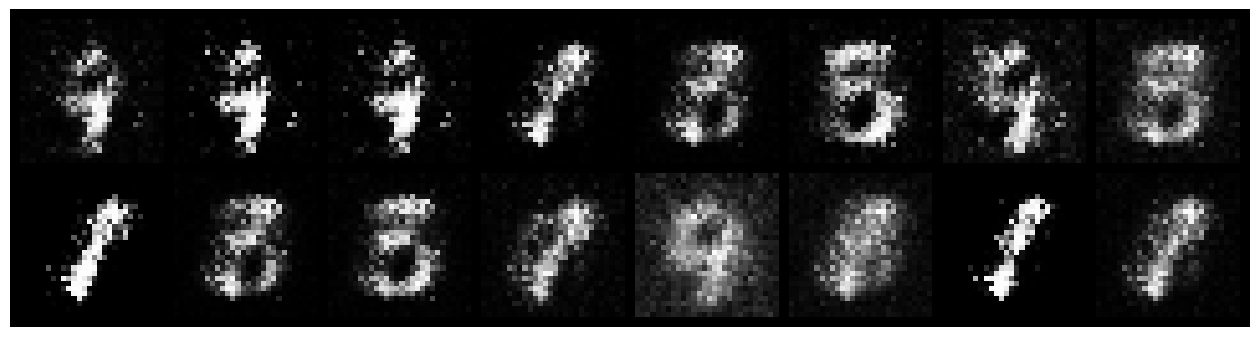

Epoch: [7/200], Batch Num: [300/600]
Discriminator Loss: 0.5068, Generator Loss: 2.5810
D(x): 0.8430, D(G(z)): 0.1501


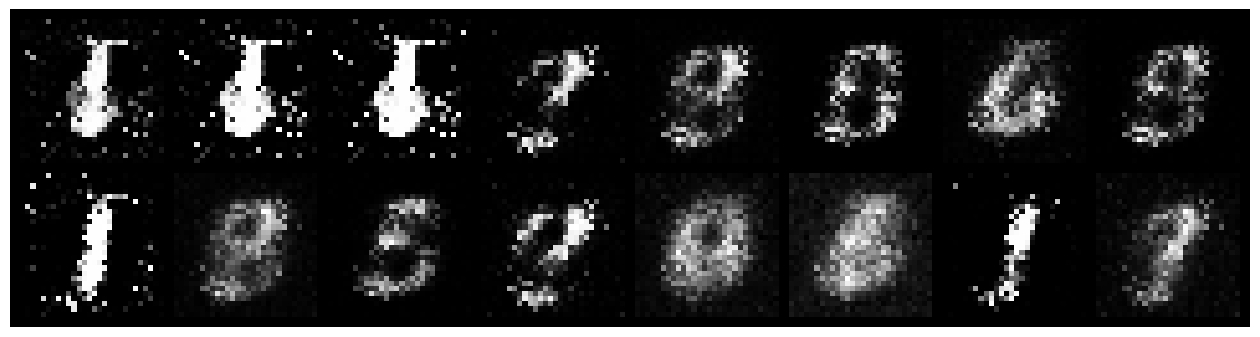

Epoch: [7/200], Batch Num: [400/600]
Discriminator Loss: 0.4817, Generator Loss: 3.0206
D(x): 0.8343, D(G(z)): 0.1628


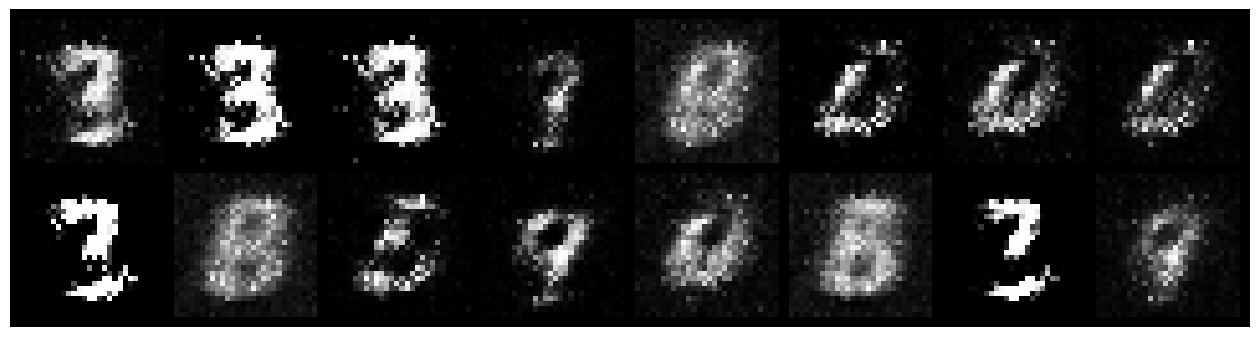

Epoch: [7/200], Batch Num: [500/600]
Discriminator Loss: 0.6720, Generator Loss: 2.2151
D(x): 0.7891, D(G(z)): 0.1593


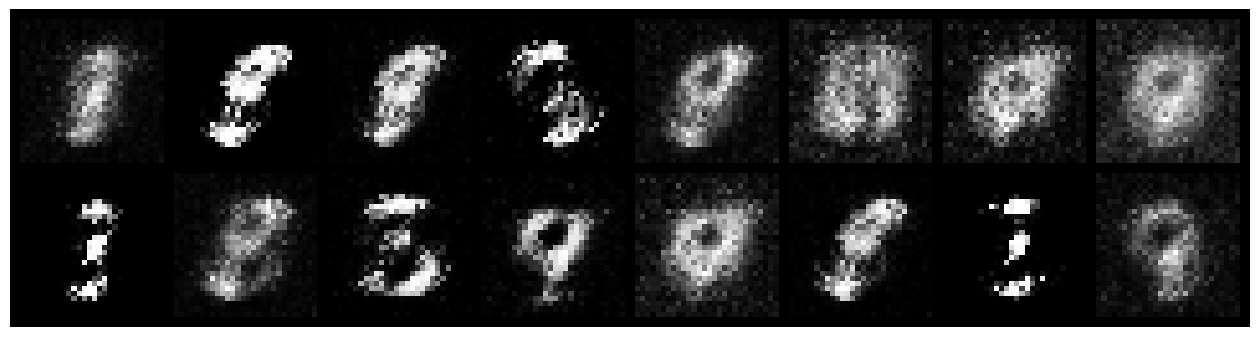

Epoch: [8/200], Batch Num: [0/600]
Discriminator Loss: 0.6416, Generator Loss: 2.0638
D(x): 0.7751, D(G(z)): 0.2109


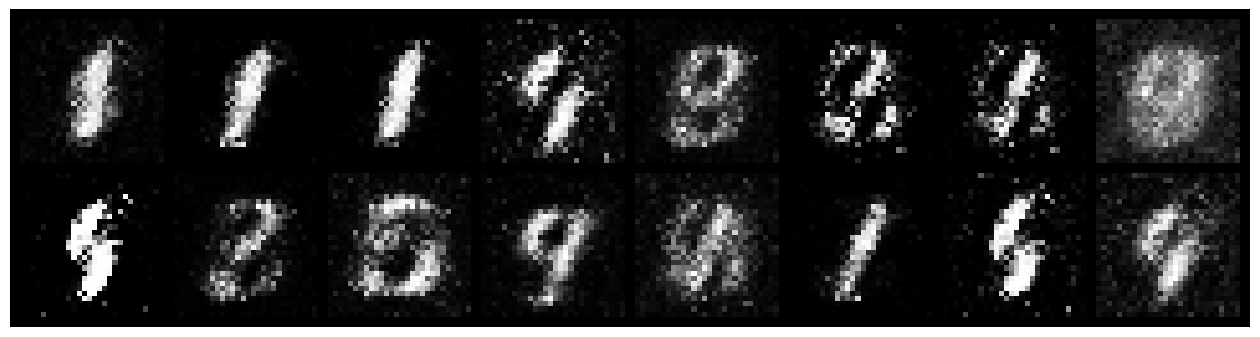

Epoch: [8/200], Batch Num: [100/600]
Discriminator Loss: 0.5352, Generator Loss: 3.0572
D(x): 0.7662, D(G(z)): 0.0980


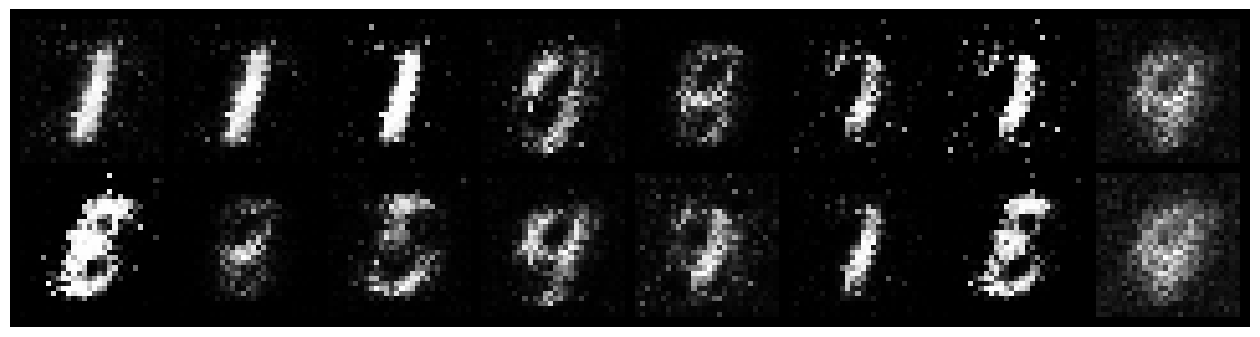

Epoch: [8/200], Batch Num: [200/600]
Discriminator Loss: 0.2968, Generator Loss: 3.3222
D(x): 0.9031, D(G(z)): 0.1143


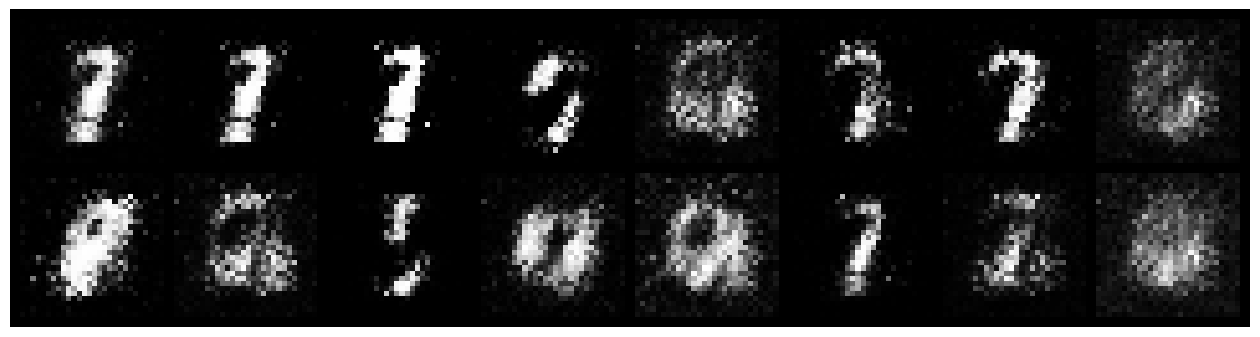

Epoch: [8/200], Batch Num: [300/600]
Discriminator Loss: 0.6170, Generator Loss: 2.9251
D(x): 0.7805, D(G(z)): 0.1685


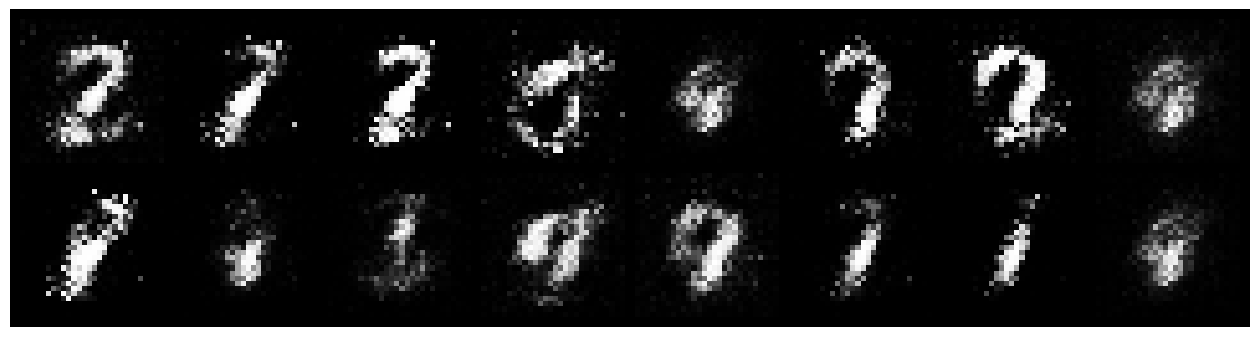

Epoch: [8/200], Batch Num: [400/600]
Discriminator Loss: 0.5432, Generator Loss: 2.9571
D(x): 0.7682, D(G(z)): 0.1059


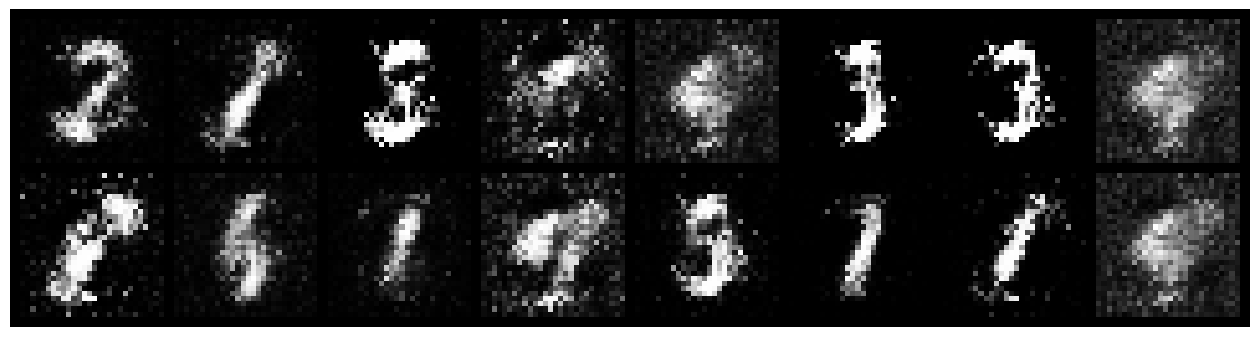

Epoch: [8/200], Batch Num: [500/600]
Discriminator Loss: 0.4911, Generator Loss: 2.7274
D(x): 0.8925, D(G(z)): 0.1934


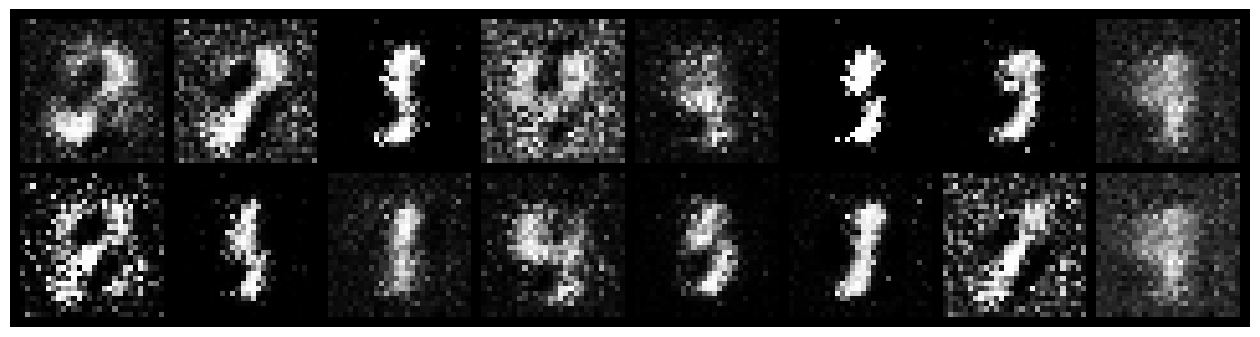

Epoch: [9/200], Batch Num: [0/600]
Discriminator Loss: 0.5079, Generator Loss: 2.4970
D(x): 0.8491, D(G(z)): 0.2062


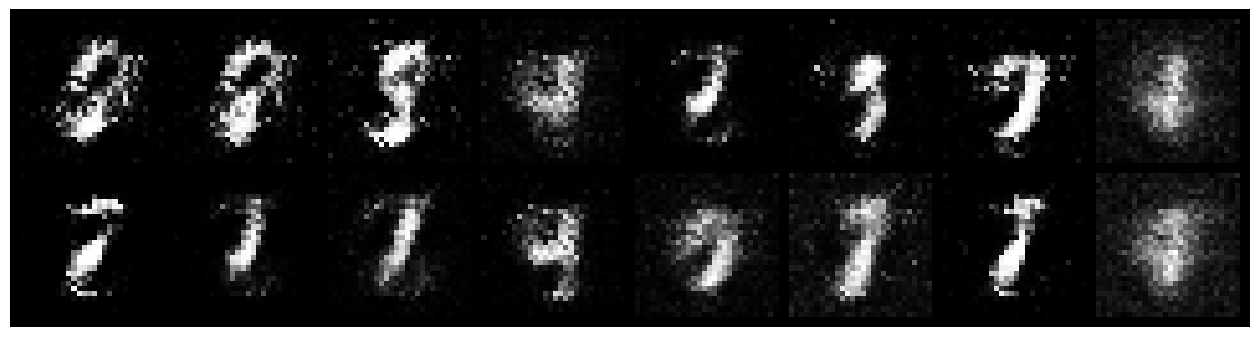

Epoch: [9/200], Batch Num: [100/600]
Discriminator Loss: 0.5192, Generator Loss: 2.8581
D(x): 0.8616, D(G(z)): 0.1756


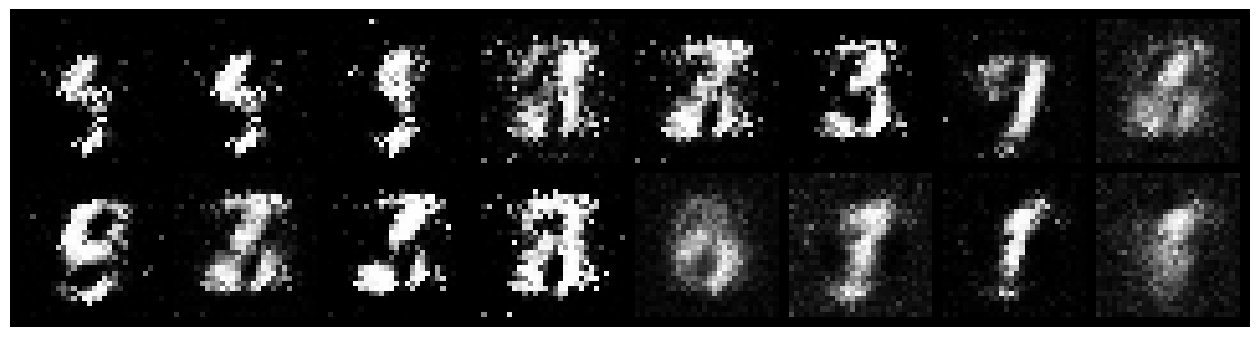

Epoch: [9/200], Batch Num: [200/600]
Discriminator Loss: 0.7417, Generator Loss: 2.1602
D(x): 0.7989, D(G(z)): 0.2588


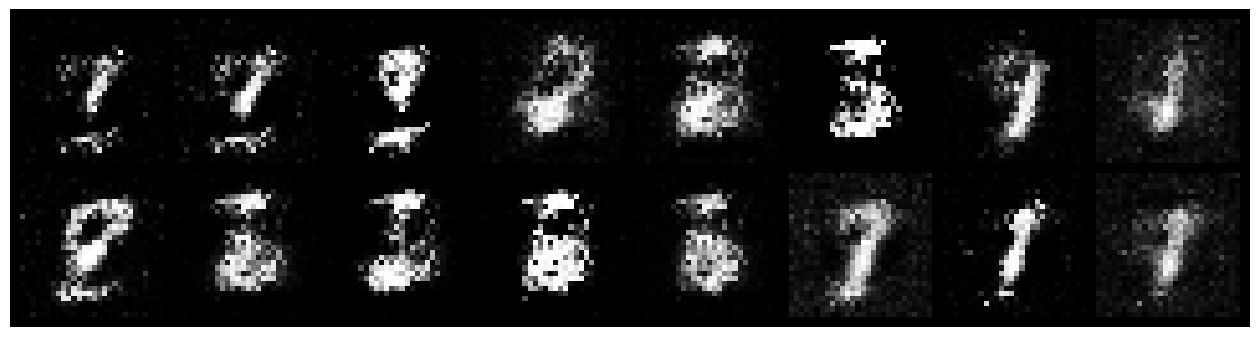

Epoch: [9/200], Batch Num: [300/600]
Discriminator Loss: 0.6326, Generator Loss: 2.2922
D(x): 0.8527, D(G(z)): 0.2199


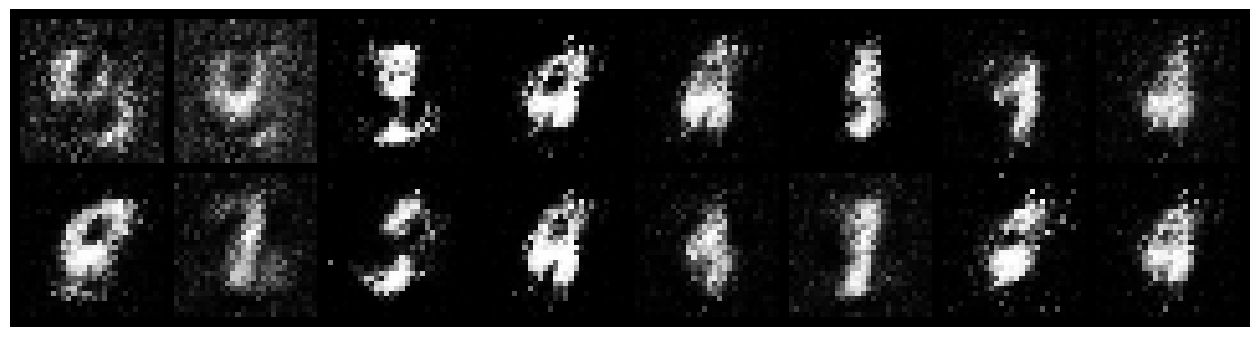

Epoch: [9/200], Batch Num: [400/600]
Discriminator Loss: 0.9142, Generator Loss: 1.7548
D(x): 0.6760, D(G(z)): 0.2666


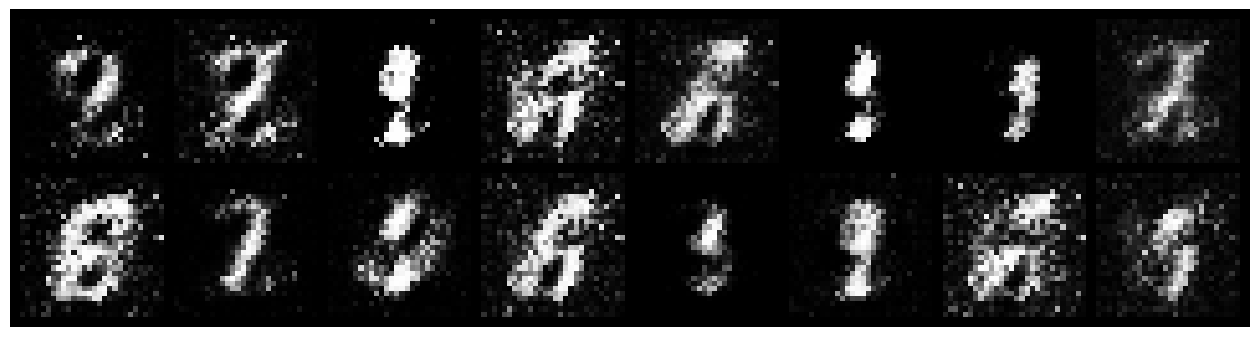

Epoch: [9/200], Batch Num: [500/600]
Discriminator Loss: 0.6760, Generator Loss: 2.2464
D(x): 0.8870, D(G(z)): 0.2874


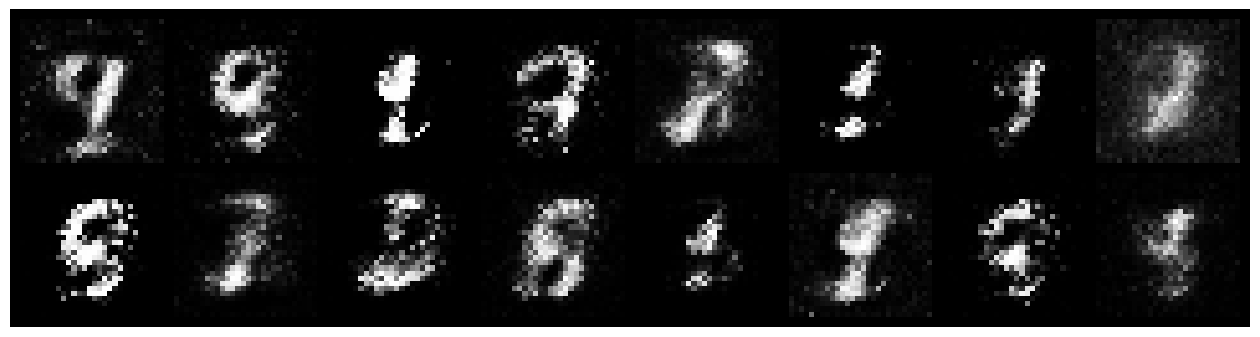

Epoch: [10/200], Batch Num: [0/600]
Discriminator Loss: 0.9337, Generator Loss: 1.6110
D(x): 0.7089, D(G(z)): 0.2866


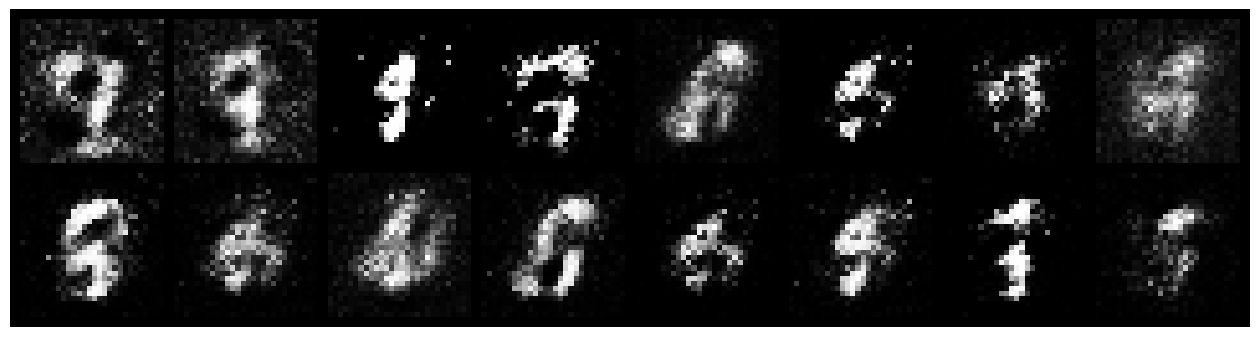

Epoch: [10/200], Batch Num: [100/600]
Discriminator Loss: 0.5424, Generator Loss: 1.7656
D(x): 0.8335, D(G(z)): 0.2161


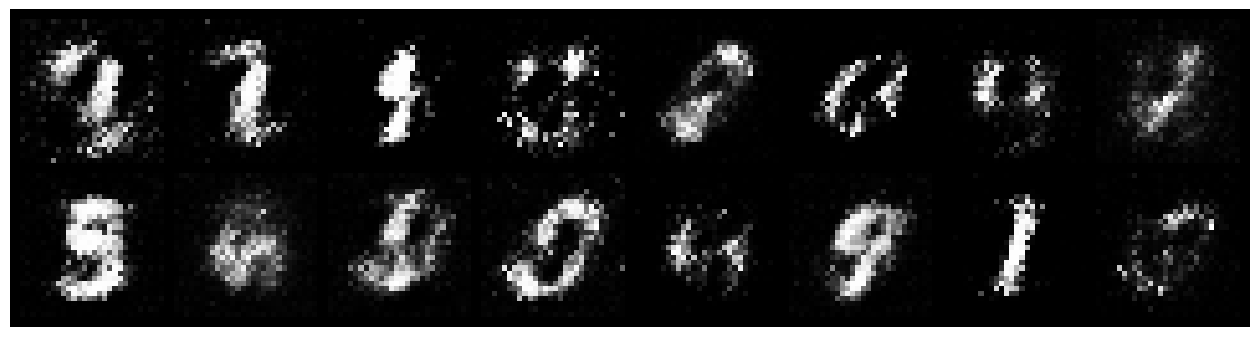

Epoch: [10/200], Batch Num: [200/600]
Discriminator Loss: 1.0232, Generator Loss: 1.6911
D(x): 0.7910, D(G(z)): 0.3881


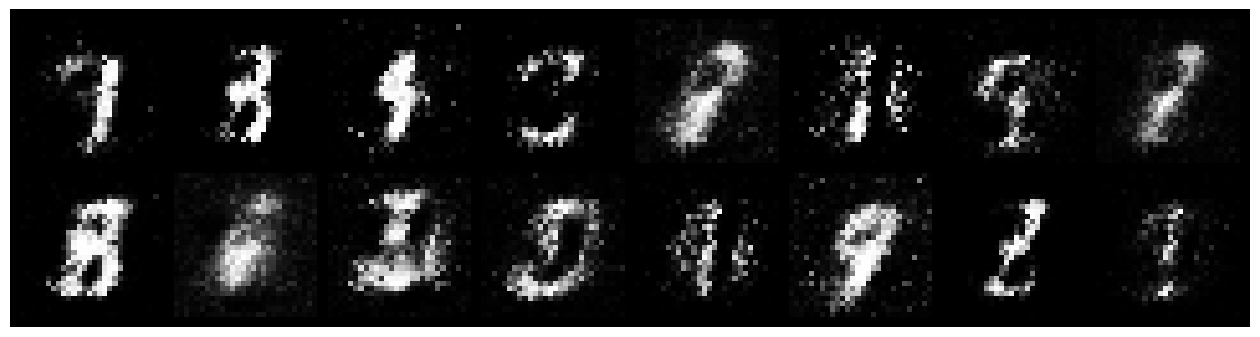

Epoch: [10/200], Batch Num: [300/600]
Discriminator Loss: 0.7967, Generator Loss: 2.0685
D(x): 0.7050, D(G(z)): 0.1939


KeyboardInterrupt: 

In [14]:
# Create logger instance (for tracking losses, images, etc.)
logger = Logger(model_name='VGAN', data_name='MNIST')

# Total number of epochs to train
num_epochs = 200

for epoch in range(num_epochs):
    for n_batch, (real_batch, _) in enumerate(data_loader):
        N = real_batch.size(0)   # Current batch size

        # ---- 1. Train Discriminator ----
        # Convert real MNIST images into flattened vectors
        real_data = Variable(images_to_vectors(real_batch))

        # Generate fake data from random noise
        # Detach to avoid gradients flowing back into generator here
        fake_data = generator(noise(N)).detach()

        # Train discriminator on real and fake data
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # ---- 2. Train Generator ----
        # Generate fake data again (this time WITH gradients)
        fake_data = generator(noise(N))

        # Train generator to fool discriminator
        g_error = train_generator(g_optimizer, fake_data)

        # ---- 3. Logging ----
        # Log batch errors (for plotting loss curves)
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Every 100 batches: generate sample images + log status
        if (n_batch) % 100 == 0: 
            # Generate test images from fixed test_noise
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data

            # Log generated images
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            )

            # Print training status (epoch, batch, losses, D predictions)
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )